In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob
import os
import unicodedata
import string
import torch
import random
import torch
import torch.nn as nn
import time
import math
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# 用于过滤掉unciode字符串中不属于英文字符的字符
all_letters = string.ascii_letters+".,;'-"
 
def findFiles(path):
    return glob.glob(path)
 
# 将Unicode编码转换成ASCII编码
def unicodeToAscii(s):
    # 'Mn'表示非间距组合记号
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' and c in all_letters)
 
# 读取文件并分成几行
def readLines(filename):
    lines = open(filename,encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]
 
# 构建category_lines字典，列表中的每行是一个类别
category_lines = {}
all_categories = []
 
for filename in findFiles("./names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    #print(lines)
    # 保存成字典：key对应类别，value对应的语种的语料
    category_lines[category] = lines
    
n_categories = len(all_categories)
print(n_categories) # 语种数量
 
if n_categories == 0:
    raise RuntimeError("Please download your data!")
print(f"Total categories:{n_categories}:{all_categories}")

5
Total categories:5:['family', 'female', 'male', 'names', 'pet']


In [3]:
# 列表中的随机项
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]
 
def randomTrainingPair():
    # 随机抽取语言
    category = randomChoice(all_categories)
    # 对语言随机抽取名字
    line = randomChoice(category_lines[category])
    #print(f"{category}:{line}")
    return category,line
 
# 类别的one-hot张量
def categoryTensor(category):
    # 获得语种列表中对应语种的索引值
    index = all_categories.index(category)
    # 构造one-hot张量:除了对应语种的值为1，其余都为0
    tensor = torch.zeros(1,n_categories)
    tensor[0][index] = 1
    return tensor
 
# 构造成对数据：（A,B）(B,C)(C,D)(D,<EOS>)
# 用于输入的从头到尾字母（不包含EOS）的one-hot张量
n_letters = len(all_letters)+1 # 添加EOS结束位
def inputTensor(line):
    # 第二维度代表逐个字母输入
    tensor = torch.zeros(len(line),1,n_letters) # n_letters：58
    # 对该单词line的每个字母遍历转换成one-hot张量
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor
 
# 用于生成目标张量
def targetTensor(line):
    # 从第二个字母开始
    letter_indexes = [all_letters.find(line[li]) for li in range(1,len(line))]
    letter_indexes.append(n_letters-1) # 添加EOS结束位
    return torch.LongTensor(letter_indexes)
 
# 构建训练集
def randomTrainingExample():
    #选择类别和对应的语料
    category,line = randomTrainingPair()
    # 将类别转成one-hot
    category_tensor = categoryTensor(category)
    # 将输入数据转成one-hot
    input_line_tensor = inputTensor(line)
    #print(input_tensor[0])
    # 标签转换
    target_line_tensor = targetTensor(line)
    #print(target.shape)
    return category_tensor,input_line_tensor,target_line_tensor
 
category_tensor,input_line_tensor,target_line_tensor = randomTrainingExample()

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        # 三层核心结构
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        # 防止过拟合，softmax对输出归一化
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        # 合并所有输入
        input_combined = torch.cat((category, input, hidden), 1)
        # 得到隐藏层
        hidden = self.i2h(input_combined)
        # 得到当前隐藏的字母信息
        output = self.i2o(input_combined)
        # 合并
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
# 调用RNN模型
print(n_letters)
rnn = RNN(n_letters,128,n_letters)
#trnn = nn.RNN(input_size=100, hidden_size=100, num_layers=1)
print(rnn)
#print(trnn)

58
RNN(
  (i2h): Linear(in_features=191, out_features=128, bias=True)
  (i2o): Linear(in_features=191, out_features=58, bias=True)
  (o2o): Linear(in_features=186, out_features=58, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [40]:
import heapq

def get_p(output):
    p = torch.exp(output)
    p = p.numpy().flatten()
    p = list(p)
    #p是概率矩阵，选出p中最大的五个值p[i]及其索引i（i = torch.nonzero(p==p[i]).squeeze()），可绘制all_letters[j]、p[j]可视化图
    #print(p.size)
    #print(p)
    p_max = heapq.nlargest(5,p)#获取前五大的值并排序
    index_max = map(p.index,p_max)#获取前五大的值下标
    p_max = list(p_max)
    index_max = list(index_max)
    letter_max = []
    for i in index_max:
        try:
            letter_max.append(all_letters[i])
            pass
        except:
            letter_max.append('end')
    #print(p_max)
    #print(index_max)#map生成的对象要转化成为list才能输出
    #print(letter_max)
    return letter_max, p_max

In [45]:
def plot_letter(letter_max, p_max):
    # 准备数据
    x_data = letter_max
    y_data = p_max

    #设置字体
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    #字符显示
    plt.rcParams["axes.unicode_minus"] = False

    # 画图，plt.bar()可以画柱状图
    for i in range(len(x_data)):
        plt.bar(x_data[i], y_data[i])
    # 设置图片名称
    plt.title("当前次预测概率最大的下一个字母及其概率图")
    # 设置x轴标签名
    plt.xlabel("字母")
    # 设置y轴标签名
    plt.ylabel("概率")
    # 显示
    plt.show()
def plots_letter(letters_max, ps_max):
    for i in range(len(letters_max)):
        if letters_max[i] ==[]:
            break
        plot_letter(letters_max[i], ps_max[i])

In [47]:
#加载模型(不用训练上面两行)
rnn=torch.load('./model/rnnmodel.pth')
# 测试
max_length = 20
 
# 来自类别和首字母的样本
def sample(category,start_letter="A",max_length=20):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
 
        output_name = start_letter.title()

        letters_max = []                  # 创建一个空列表
        ps_max = []                  # 创建一个空列表
 
        for i in range(max_length):
            output,hidden = rnn(category_tensor,input[0],hidden)
            # 采用可视化技术，绘制出模型为每个时刻预测的前5个最可能的候选字母。 
            # top函数用来提取最大概率的值和索引，也可以用torch.max函数
            # topv,topi = output.topk(1)
            # topi = topi[0][0]
            #print("output", output)
            #print("hidden", hidden)
            '''
            if i == 1:
                p = torch.exp(output)
                p = p.numpy().flatten()
                #p是概率矩阵，选出p中最大的五个值p[i]及其索引i（i = torch.nonzero(p==p[i]).squeeze()），可绘制all_letters[j]、p[j]可视化图
                print(p.size)
                print(p)
                for j in range(p.size):
                    print(j)
                    print(all_letters[j],p[j])
            '''
            _,pred = torch.max(output.data,dim=1)
            topi = pred
            #print(_)
            letter_max, p_max = get_p(output)
            #print(letter_max)
            letters_max.append(letter_max)
            ps_max.append(p_max)
            # 如果预测为EOS的索引，则跳出循环
            if topi == n_letters -1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            
            # 当前预测的字母作为下一个时刻的输入
            input = inputTensor(letter)
        #print("生成单个名字，应该是二维列表",letters_max)
        return output_name, letters_max, ps_max

# 来自类别和结尾字母的样本
def sample_last(category, end_letter='a'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        # 用零向量表示生成名字的开始
        input = torch.zeros(1, 1, n_letters)
        hidden = rnn.initHidden()

        output_name = ''

        # 将给定的结尾字母转换为对应的 one-hot 张量
        end_letter_tensor = inputTensor(end_letter)

        # 从给定的结尾字母开始生成
        for i in range(max_length):
            letter = 0
            while letter == 0:
                output, hidden = rnn(category_tensor, input[0], hidden)
                #hidden = rnn.initHidden()
                _, pred = torch.max(output.data, dim=1)
                topi = pred.item()

                try:
                    letter = all_letters[topi]
                    pass
                except:
                    pass
            
            if i == 0:
                letter = letter.title()
            elif letter == end_letter:
                e_output, e_hidden = rnn(category_tensor, end_letter_tensor[0], hidden)
                _, e_pred = torch.max(e_output.data, dim=1)
                e_topi = e_pred.item()
                if e_topi == n_letters - 1:
                    output_name = output_name + letter
                    break
            elif letter.isupper():
                break

            output_name = output_name + letter

            # 当前预测的字母作为下一个时刻的输入
            input = inputTensor(letter)
        #print(type(output_name))
        if output_name[-1] != end_letter:
            output_name = ''
            #print("抱歉，我暂时不能生成以",end_letter,"结尾的名字")

        return output_name

# 来自类别和任意位置字母的样本，方便用户使用，这里首位为1
def sample_any(category, given_name='abc', start_position=1):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        # 用零向量表示生成名字左边的开始
        input = torch.zeros(1, 1, n_letters)
        # 从给定的结尾字母开始生成
        if start_position < 2:
            output_name = sample(category,given_name)
        elif start_position >= 2:
            j = 0
            e_letter = ''
            while (e_letter != given_name[0].lower()) and (j<50):
                l_output_name = ''
                hidden = rnn.initHidden()
                for i in range(start_position-2):
                    letter = 0
                    while letter == 0:
                        output, hidden = rnn(category_tensor, input[0], hidden)
                        #hidden = rnn.initHidden()
                        _, pred = torch.max(output.data, dim=1)
                        topi = pred.item()
                        try:
                            letter = all_letters[topi]
                            pass
                        except:
                            pass            
                    if i == 0:
                        letter = letter.title()
                    elif i == (start_position-1):
                        e_output, e_hidden = rnn(category_tensor, end_letter_tensor[0], hidden)
                        _, e_pred = torch.max(e_output.data, dim=1)
                        e_topi = e_pred.item()
                        e_letter = all_letters[e_topi]
                    elif letter.isupper():
                        break
                    l_output_name = l_output_name + letter
                    # 当前预测的字母作为下一个时刻的输入
                    input = inputTensor(letter)
                #print(type(output_name))
                j += 1
            if (len(l_output_name) != (start_position-1)):
                output_name = ''
            else:
                r_output_name = given_name - given_name[-1] + sample(category,given_name[-1],max_length-len(given_name)+1)
                output_name = l_output_name + r_output_name.lower()
        return output_name

#sample_any("names", given_name='a', start_position=1)

# 从一个类别和多个首字母中获取多个样本
def samples(category,start_letters='ABC',num=1):
    print("我将为您生成满足您要求的名字：")
    #print(len(start_letters))
    letters_max = []                  # 创建一个空列表
    #print(letters_max)                # 输出列表
    ps_max = []                  # 创建一个空列表
    #print(ps_max)                # 输出列表

    for start_letter in start_letters:
        name1, letter_max1, p_max1 = sample(category,start_letter,max_length)
        #name1 = sample_last(category,start_letter)
        name = []
        name.append(name1)
        letters_max.append(letter_max1)
        ps_max.append(p_max1)
        
        for i in range(num-1):
            i_name,i_letter_max,i_p_max = sample(category,start_letter,max_length)
            #i_name = sample_last(category,start_letter)
            #print("新生成的：",i_name)
            for get_name in name:
                #print("已有的名字：",get_name)
                j = 0
                while (get_name == i_name) and (j < 50):
                    i_name,i_letter_max,i_p_max = sample(category,start_letter,max_length)
                    #i_name = sample_last(category,start_letter)
                    j += 1
            name.append(i_name)
            letters_max.append(i_letter_max)
            ps_max.append(i_p_max)    
        if len(name) != num:
            print("抱歉，我不能找到足够满足您要求的以", start_letter, "开头的名字")
        for n in name:
            print(n)
    #print("带多个名字索引的，应该是三维列表",letters_max)
    return letters_max, ps_max

# 从一个类别和多个结尾字母中获取多个样本
def samples_last(category,end_letters='abc',num=1):
    print("我将为您生成满足您要求的名字：")
    for end_letter in end_letters:
        j = 0
        name = []
        name1 = sample_last(category,end_letter)
        while (name1 =='') and (j < 50):
            name1 = sample_last(category,end_letter)
            j += 1
        if name1 != '':
            name.append(name1)
        
            for i in range(num-1):
                i_name = sample_last(category,end_letter)
                #print("新生成的：",i_name)
                j = 0
                while (i_name =='') and (j < 50):
                    i_name = sample_last(category,end_letter)
                    j += 1
                for get_name in name:
                    #print("已有的名字：",get_name)
                    j = 0
                    while (get_name == i_name) and (j < 50):
                        i_name = sample_last(category,end_letter)
                        j += 1
                if i_name == '':
                    #print("抱歉，我暂时不能生成更多以",end_letter,"结尾的名字")
                    break
                name.append(i_name)
        if len(name) != num:
            print("抱歉，我不能找到足够满足您要求的以", end_letter, "结尾的名字")
        try:
            for n in name:
                print(n)
            pass
        except:
            pass

# 从一个类别和多个给定任意字母中获取多个样本
def samples_any(category,letter='Abc',num=1,start_position=1):
    print("我将为您生成满足您要求的名字：")
    #for letter in letters:
    j = 0
    name1 = sample_any(category,letter,start_position)
    name = []
    while (name1 =='') and (j < 50):
        name1 = sample_any(category,letter,start_position)
        j += 1
    if name1 != '':
        name.append(name1)        
        for i in range(num-1):
            #print(i)
            i_name = sample_any(category,letter,start_position)
            #print("新生成的：",i_name)
            for get_name in name:
                #print("已有的名字：",get_name)
                j = 0
                while (get_name == i_name) and (j < 50):
                    i_name = sample_any(category,letter,start_position)
                    j += 1
            name.append(i_name)
    if len(name) != num:
        print("抱歉，我不能找到足够满足您要求的包含", letter, "在第", start_position, "位","的名字")
    for n in name:
        print(n)

#samples_any(category,letter='Abc',num=1,start_position=3)

def switch_lebel(argument):
    if argument == 0:
        lebel = "names"
    elif argument == 1:
        lebel = "family"
    elif argument == 2:
        lebel = "male"
    elif argument == 3:
        lebel = "female"
    elif argument == 4:
        lebel = "pet"
    else:
        # 默认操作
        lebel = "names"
        print("无效输入，默认您没有要求")
    return lebel

In [54]:
def switch_mode(mode, lebel="names", data='A'):
    #print(len(data))
    try:
        num = int(input("请告诉我对每个字母，你想生成几个name："))
        pass
    except ValueError:
        num = 1
        print("无效输入，默认生成一个")
        pass
    if mode == 0:
        letters_max, ps_max = samples(lebel, data, num)
        print("你可以选择你喜欢的名字查看他的生成过程，我将为您生成每一步前五可能的预测概率图")
        try:
            see = int(input("如果查看，请输入第几个，如果不查看请输入0：（1代表我为您生成的第一个）"))
            pass
        except ValueError:
            see = 0
            print("无效输入，默认您不查看")
            pass
        if see > num*len(data):
            print("无效输入，默认您不查看")
        elif see != 0:
            #print(letters_max[see-1])
            plots_letter(letters_max[see-1], ps_max[see-1])

    elif mode == 1:
        samples_last(lebel, data, num)
    elif mode == 2:
        try:
            start = int(input("请指定你想要的出现位置："))
            pass
        except ValueError:
            start = 1
            print("无效输入，默认出现在开头")
            pass
        if start > max_length-len(data):
            start = max_length-len(data)
            print("无效输入，您的指定位置超出了目前允许最大名字长度：",max_length ,"，默认出现在结尾")
        samples_any(lebel, data, num, start)
    else:
        print("无效输入，默认开头")
        letters_max, ps_max = samples(lebel, data, num)
        print("你可以选择你喜欢的名字查看他的生成过程，我将为您生成每一步前五可能的预测概率图")
        try:
            see = int(input("如果查看，请输入第几个，如果不查看请输入0：（1代表我为您生成的第一个）"))
            pass
        except ValueError:
            see = 0
            print("无效输入，默认您不查看")
            pass
        if see > num*len(data):
            print("无效输入，默认您不查看")
        elif see != 0:
            plot_letter(letters_max[see-1], ps_max[see-1])

0 没有要求, 1 生成姓, 2 男性, 3 女性, 4 宠物 
请告诉我你想要获取的name类型并输入相应的字符：0
请告诉我你想要包含的字母，可以有多个，连续输入即可：AS
0 开头, 1 结尾, 2 我要任意指定
请告诉我你希望这些字母出现在哪个位置：0
2
请告诉我对每个字母，你想生成几个name：3
我将为您生成满足您要求的名字：
2
Allen
Allest
Aller
Shardon
Shamber
Stoop
你可以选择你喜欢的名字查看他的生成过程，我将为您生成每一步前五可能的预测概率图
如果查看，请输入第几个，如果不查看请输入0：（1代表我为您生成的第一个）6


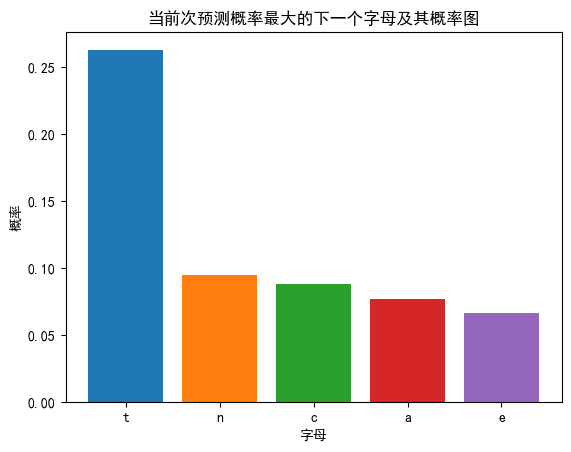

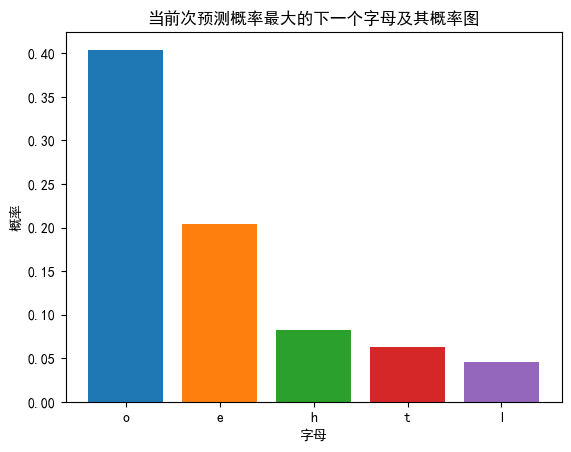

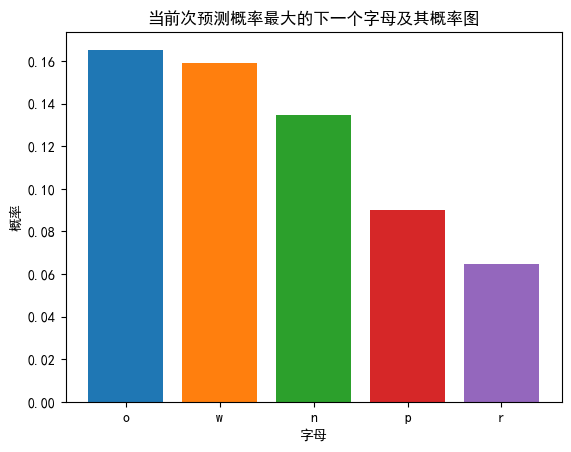

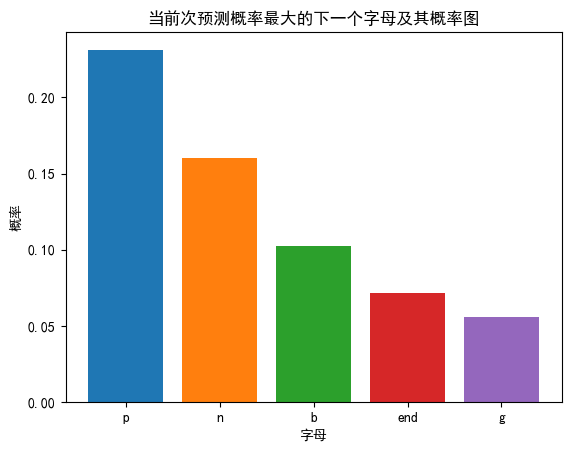

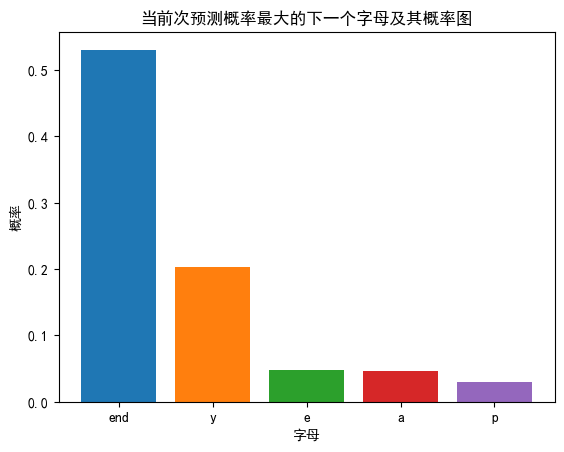

生成完毕，0 退出，1 继续：0
感谢使用


In [55]:
a = 1
while a == 1:
    print("0 没有要求, 1 生成姓, 2 男性, 3 女性, 4 宠物 ")
    try:
        lebel_num = int(input("请告诉我你想要获取的name类型并输入相应的字符："))
        pass
    except ValueError:
        lebel_num = -1
        pass
    lebel = switch_lebel(lebel_num)
    data = input("请告诉我你想要包含的字母，可以有多个，连续输入即可：")
    print("0 开头, 1 结尾, 2 我要任意指定")
    try:
        mode = int(input("请告诉我你希望这些字母出现在哪个位置："))
        pass
    except ValueError:
        mode = 0
        print("无效输入，默认开头")
        pass
    switch_mode(mode, lebel, data)
    try:
        a = int(input("生成完毕，0 退出，1 继续："))
        pass
    except ValueError:
        a = -1
        pass
    if a != 0 and a != 1:
        print("无效输入，默认退出")
print("感谢使用")